In [3]:
import torch
import torch.nn as nn
import sys

from flashdiv.flows.trainer import FlowTrainer, DistillationTrainer
from flashdiv.lj.lj import LJ


import matplotlib.pyplot as plt
from einops import rearrange, repeat, reduce, einsum
import math

from torch.utils.data import DataLoader, Dataset, random_split
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import numpy as np


import torch.nn.functional as F
from torch.func import jvp
import math
%load_ext autoreload
%autoreload 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from flashdiv.flows.eqtf_com import EqTransformerFlowSherryVariation
from flashdiv.flows.trainer import FlowTrainer
from flashdiv.flows.egnn_et import EasyTrace_EGNN
from flashdiv.flows.etvf import EasyTraceVelocityField
from flashdiv.flows.eqtf_pair import EqTransformerFlow as EqTransformerFlow_pair
from flashdiv.flows.eqtf_gen import EqTransformerFlow as EqTransformerFlow
from flashdiv.flows.new_vf import EqTransformerFlow as NewEqTransformerFlow
from flashdiv.flows.egnn_new.egnn import EGNN_dynamics_Noe
from flashdiv.flows.egnn import EGNN_dynamics



from types import SimpleNamespace    # lightweight stand-in for argparse.Namespace


#plt.style.use('my_style')
#use default matplotlib style
plt.style.use('default')

# Example scripe

plt.rcParams.update({'text.usetex': True,
                     'font.family': 'CMU',
                     'text.latex.preamble': r'\usepackage{amsfonts}'})

In [2]:

def lennard_jones_energy_torch(r, eps=1.0, rm=1.0):
    lj = eps * ((rm / r) ** 12 - 2 * (rm / r) ** 6)
    return lj

def tile(a, dim, n_tile):
    """
    Tiles a pytorch tensor along one an arbitrary dimension.

    Parameters
    ----------
    a : PyTorch tensor
        the tensor which is to be tiled
    dim : Integer
        dimension along the tensor is tiled
    n_tile : Integer
        number of tiles

    Returns
    -------
    b : PyTorch tensor
        the tensor with dimension `dim` tiled `n_tile` times
    """
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = np.concatenate(
        [init_dim * np.arange(n_tile) + i for i in range(init_dim)]
    )
    order_index = torch.LongTensor(order_index).to(a).long()
    return torch.index_select(a, dim, order_index)

def distance_vectors(x, remove_diagonal=True):
    r"""
    Computes the matrix :math:`r` of all distance vectors between
    given input points where

    .. math::
        r_{ij} = x_{i} - y_{j}

    as used in :footcite:`Khler2020EquivariantFE`

    Parameters
    ----------
    x : torch.Tensor
        Tensor of shape `[n_batch, n_particles, n_dimensions]`
        containing input points.
    remove_diagonal : boolean
        Flag indicating whether the all-zero distance vectors
        `x_i - x_i` should be included in the result

    Returns
    -------
    r : torch.Tensor
        Matrix of all distance vectors r.
        If `remove_diagonal=True` this is a tensor of shape
            `[n_batch, n_particles, n_particles, n_dimensions]`.
        Otherwise this is a tensor of shape
            `[n_batch, n_particles, n_particles - 1, n_dimensions]`.

    Examples
    --------
    TODO

    References
    ----------
    .. footbibliography::

    """
    r = tile(x.unsqueeze(2), 2, x.shape[1])
    r = r - r.permute([0, 2, 1, 3])
    if remove_diagonal:
        r = r[:, torch.eye(x.shape[1], x.shape[1]) == 0].view(
            -1, x.shape[1], x.shape[1] - 1, x.shape[2]
        )
    return r

def distances_from_vectors(r, eps=1e-6):
    """
    Computes the all-distance matrix from given distance vectors.
    
    Parameters
    ----------
    r : torch.Tensor
        Matrix of all distance vectors r.
        Tensor of shape `[n_batch, n_particles, n_other_particles, n_dimensions]`
    eps : Small real number.
        Regularizer to avoid division by zero.
    
    Returns
    -------
    d : torch.Tensor
        All-distance matrix d.
        Tensor of shape `[n_batch, n_particles, n_other_particles]`.
    """
    return (r.pow(2).sum(dim=-1) + eps).sqrt()

def _remove_mean(x):
        return x - torch.mean(x, dim=-2, keepdim=True)

def lj_energy(x, oscillator_scale=0):
    batch_size = x.shape[0]
    n_particles = x.shape[1]
    n_dims = x.shape[2]

    dists = distances_from_vectors(
        distance_vectors(x.view(-1, n_particles, n_dims))
    )

    lj_energies = lennard_jones_energy_torch(dists, 1.0, 1.0)
    lj_energies = lj_energies.view(batch_size, -1).sum(dim=-1) #/ 2

    if oscillator_scale > 0:
        osc_energies = 0.5 * _remove_mean(x).pow(2).sum(dim=(-2, -1)).flatten()
        lj_energies = lj_energies + osc_energies * oscillator_scale

    return lj_energies

torch.Size([1000, 13, 3])


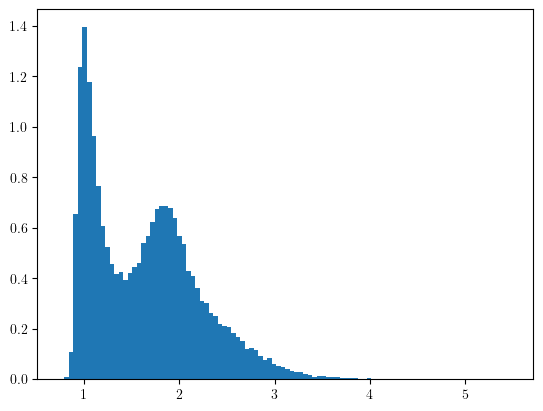

In [3]:
nbparticles = 13
dim = 3
boxlength = (nbparticles) ** (1/dim)
temp = 0.5
# lj = torch.tensor(np.load(f'lj9_2d_nonperiodic_1.0.npy', mmap_mode='r')[:,:int(10)])
# data = np.load('lj9_2d_nonperiodic_1.0.npy', mmap_mode='r')
data = torch.tensor(np.load(f'lj13_samples_noe_reflow.npy', mmap_mode='r'))[1][::1000].to(device)
print(data.shape)
# center them
# lj-= lj.mean(dim=1, keepdim=True)
ljsystem = LJ(  
  nparticles=nbparticles,
  dim=dim,
  device=device,
  boxlength= boxlength,
  kT=0.5,
  sigma = 1/(2**(1/6)),
  shift=False,
  spring_constant = 0.5,
  periodic=False)


ref_potential = ljsystem.potential(data, turn_off_harmonic=False).flatten()
log_likelihood = ljsystem.log_likelihood(data)
ref_bin, ref_g_r = ljsystem.g_r(data, bins=200)
# pairwise distances
dists = torch.norm(data.unsqueeze(2) - data.unsqueeze(1), dim=-1)  # shape (batch, N, N)
mask = ~torch.eye(data.shape[1], device=data.device).bool()
dists = dists[:, mask].reshape(-1)
plt.hist(dists.cpu().numpy(), bins=100, density=True)
plt.show()


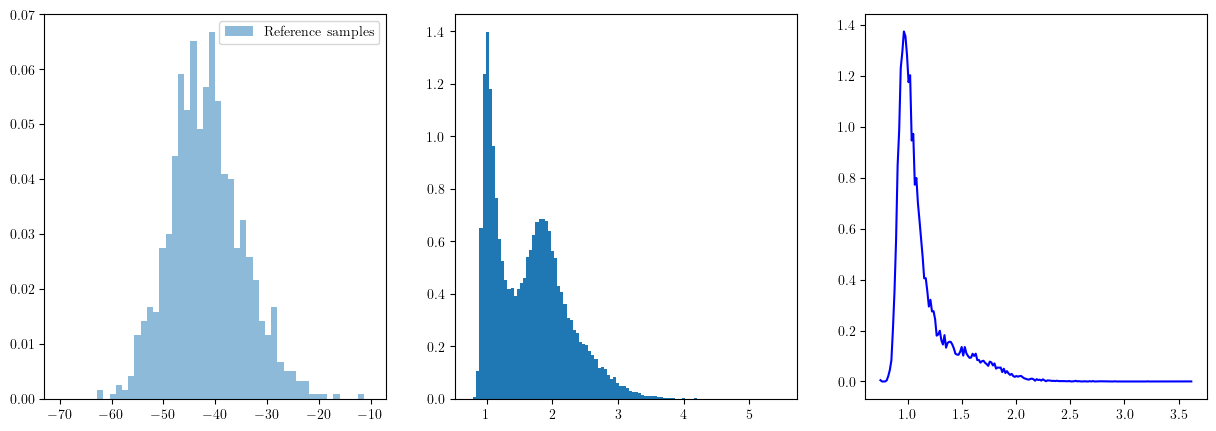

% of sub 0 ref energy confs : 99.90000915527344



In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
pot = lj_energy(data,oscillator_scale=1.0)
ax[0].hist(pot.cpu().numpy(), bins=50, density=True, alpha=0.5, label='Reference samples',range=(-70,-10))
#ax[0].hist(ljsystem.potential(data, turn_off_harmonic=False).cpu().numpy(), bins=50, density=True, alpha=0.5, label='No harmonic')
ax[0].legend()
# ax[0].show()


ax[1].hist(dists.cpu().numpy(), bins=100, density=True)

ax[2].plot(ref_bin[:-1], ref_g_r, label='Reference samples', color='blue')
# ax[1].set_yscale('log')
plt.show()

print(f'% of sub 0 ref energy confs : {((ref_potential < 0).sum() / ref_potential.shape[0]) * 100}\n')

In [5]:
def parse_args(args):
    if args.nn == 'egnn':
        velocitynet = EGNN_dynamics(n_particles=nbparticles, n_dimension=dim, device=device, hidden_nf=int(args.gnn_hidden_dim),
        act_fn=torch.nn.SiLU(), n_layers=int(args.nb_layers), recurrent=True, tanh=True, attention=True, agg='sum')
    elif args.nn == 'egnn_et':
        velocitynet = EasyTrace_EGNN(n_particles=nbparticles, hidden_nf=int(args.gnn_hidden_dim),
            act_fn=torch.nn.SiLU(), n_layers=int(args.nb_layers), recurrent=True, tanh=True, attention=True, agg='sum')
    elif args.nn == "etvf":
        velocitynet = EasyTraceVelocityField(n_particles=nbparticles,gnn_hidden_dim = int(args.gnn_hidden_dim),
                                            tf_hidden_dim = int(args.tf_hidden_dim),act_fn=torch.nn.SiLU(), n_layers=int(args.nb_layers), 
                                            recurrent=True, tanh=True, attention=True, agg='sum')
    elif args.nn == "eqtf_sherry":
        velocitynet = EqTransformerFlowSherryVariation(
            input_dim=3,
            embed_dim=int(args.tf_hidden_dim))
    elif args.nn == "eqtf_pair":
        velocitynet = EqTransformerFlow_pair(
            n_particles=nbparticles,
            hidden_nf=int(args.tf_hidden_dim))
    elif args.nn == "eqtf":
        velocitynet = EqTransformerFlow(
        n_particles=nbparticles,
        hidden_nf=int(args.tf_hidden_dim))
    elif args.nn == "new_vf":
        velocitynet = NewEqTransformerFlow(
        n_particles=nbparticles,
        hidden_nf=int(args.tf_hidden_dim),
        gnn_hidden_nf=int(args.gnn_hidden_dim),
        )
    elif args.nn == "egnn_noe":
        velocitynet = EGNN_dynamics_Noe(
        n_particles=nbparticles - 1,
        device=device,
        n_dimension=dim,
        hidden_nf=12,
        act_fn=torch.nn.SiLU(),
        n_layers=2,
        recurrent=True,
        tanh=True,
        attention=True,
        condition_time=True,
        # in_node_nf=1,  # 1 for time, 2 for position
        out_node_nf=12, # expressivity for potential
        )
    return velocitynet

In [6]:
def load_model(nn,ckpt_path):
    args = SimpleNamespace(
        nn=nn,            # pick one of: "egnn", "etvf", "eqtf_sherry", "eqtf"
        gnn_hidden_dim=32,
        tf_hidden_dim=256,
        nb_layers=4
    )

    velocitynet = parse_args(args)
    ckpt = torch.load(ckpt_path, map_location='cuda')

    # Assume `ckpt` is a raw state_dict, or nested inside a dict under "state_dict"
    if 'state_dict' in ckpt:
        state_dict = ckpt['state_dict']
    else:
        state_dict = ckpt

    velocityTrainer = FlowTrainer(velocitynet)
    velocityTrainer.load_state_dict(state_dict)
    # # velociTrainer = FlowTrainer.load_from_checkpoint(flow_model = velocitynet) #
    velocitynet = velocityTrainer.flow_model.to(device)
    print(f"nb params : {sum(p.numel() for p in velocityTrainer.parameters())}")
    return velocitynet

In [1]:
import torch

# Load the dictionary
results = torch.load('egnn_results.pt')

# Access the fields
xt = results['xt']
target_log_prob = results['target_log_prob']
x0_list = results['x0_list']

vf_results = torch.load('new_vf_results.pt')
# Access the fields
vf_xt = vf_results['xt']
vf_target_log_prob = vf_results['target_log_prob']
vf_x0_list = vf_results['x0_list']

In [16]:
def effective_sample_size(log_weights):
    """Kish effective sample size; log weights don't have to be normalized"""
    return torch.exp(2*torch.logsumexp(log_weights, dim=0) - torch.logsumexp(2*log_weights, dim=0))


def sampling_efficiency(log_weights):
    """Kish effective sample size / sample size; log weights don't have to be normalized"""
    return effective_sample_size(log_weights) / len(log_weights)

def compute_potential_and_weights(xt, target_log_prob):
    potential = lj_energy(xt, oscillator_scale=1.0)
    weights = torch.exp(-potential)/ torch.exp(target_log_prob)
    weights /= weights.max()  # shift weights
    ess = sampling_efficiency(torch.log(weights))
    return potential, weights, ess

def plot_potential_vs_target_log_prob(potential, target_log_prob, weights):
    weights_norm = (weights / weights.sum()).cpu().numpy()
    print("max weights:", weights_norm.max().item())
    from matplotlib.colors import LogNorm
    sc = plt.scatter(target_log_prob.cpu().numpy(), potential.cpu().numpy(),c=weights_norm,cmap='coolwarm', norm=LogNorm())
    plt.colorbar(sc, label='Normalized Weight)')
    plt.xlabel("Target Log Probability")
    plt.ylabel("LJ Potential")
    plt.ylim(-70, 0)
    plt.xlim(-30, 40)
    plt.show()
    

max weights: 0.015840135514736176


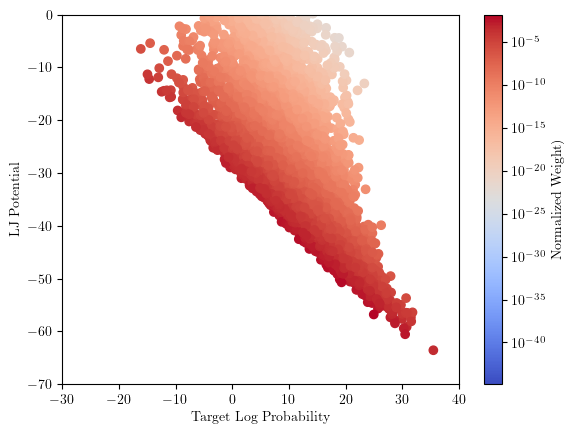

max weights: 0.45982661843299866


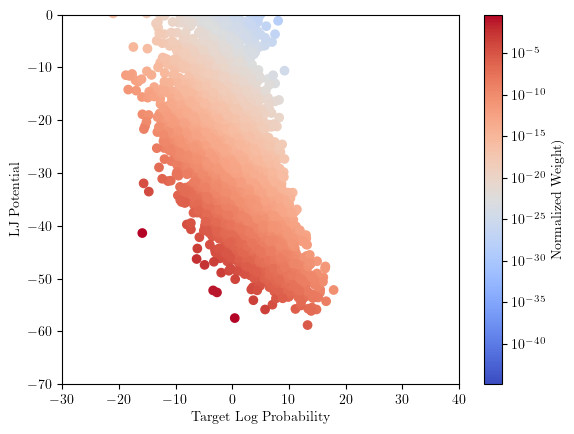

In [17]:
potential_egnn, weights_egnn, ess_egnn = compute_potential_and_weights(xt, target_log_prob)
potential_new_vf, weights_new_vf, ess_new_vf = compute_potential_and_weights(vf_xt, vf_target_log_prob)
plot_potential_vs_target_log_prob(potential_egnn, target_log_prob, weights_egnn)
plot_potential_vs_target_log_prob(potential_new_vf, vf_target_log_prob, weights_new_vf)

In [6]:
print(f"Effective sample size egnn: {ess_egnn:.2f}")
print(f"Effective sample size new vf: {ess_new_vf:.2f}")

Effective sample size egnn: 0.07
Effective sample size new vf: 0.00


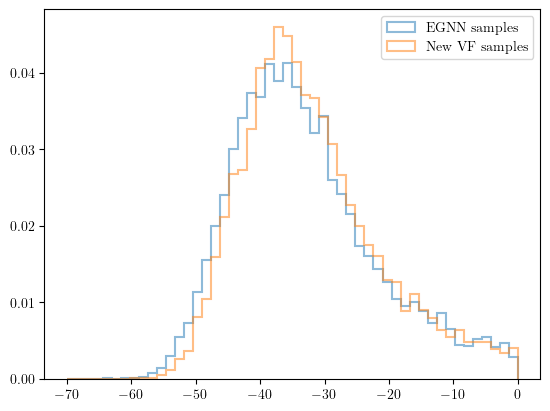

In [9]:
plt.hist(potential_egnn.cpu().numpy(), bins=50, density=True, alpha=0.5, label='EGNN samples',range=(-70,0),histtype='step',fill=False,linewidth=1.5)
plt.hist(potential_new_vf.cpu().numpy(), bins=50, density=True, alpha=0.5, label='New VF samples',range=(-70,0), histtype='step',fill=False,linewidth=1.5)
plt.legend()
plt.show()  

In [17]:
xt1, target_log_prob1, weights1, dists_v1 = generate_samples_and_prob(egnn)

0
torch.Size([50, 13, 3]) torch.Size([50])
torch.Size([50, 13, 3]) torch.Size([50])
2
torch.Size([50, 13, 3]) torch.Size([50])
torch.Size([50, 13, 3]) torch.Size([50])


In [19]:
def effective_sample_size(log_weights):
    """Kish effective sample size; log weights don't have to be normalized"""
    return torch.exp(2*torch.logsumexp(log_weights, dim=0) - torch.logsumexp(2*log_weights, dim=0))


def sampling_efficiency(log_weights):
    """Kish effective sample size / sample size; log weights don't have to be normalized"""
    return effective_sample_size(log_weights) / len(log_weights)

In [21]:
sampling_efficiency(weights1.log())

tensor(0.5572, device='cuda:0')

In [22]:
xt2, target_log_prob2, weights2, dists_v2 = generate_samples_and_prob(egnn_noe)
xt3, target_log_prob3, weights3, dists_v3 = generate_samples_and_prob(new_vf)

0
torch.Size([50, 13, 3]) torch.Size([50])
torch.Size([50, 13, 3]) torch.Size([50])
2
torch.Size([50, 13, 3]) torch.Size([50])
torch.Size([50, 13, 3]) torch.Size([50])
0
torch.Size([50, 13, 3]) torch.Size([50])
torch.Size([50, 13, 3]) torch.Size([50])
2


KeyboardInterrupt: 

In [24]:
pot = lj_energy(xt2,oscillator_scale=1.0)

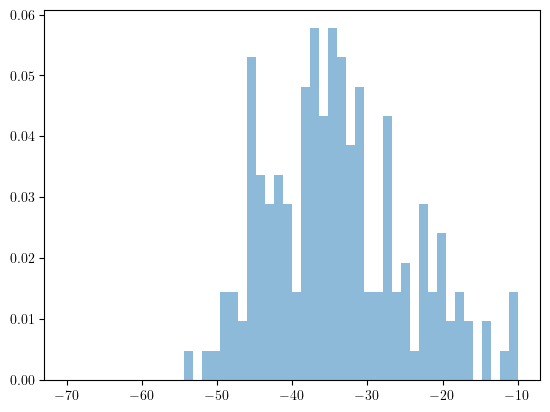

In [25]:
plt.hist(pot.cpu().numpy(), bins=50, density=True, alpha=0.5, label='EqTF samples',range=(-70,-10))
plt.show()

In [23]:
sampling_efficiency(weights2.log())

tensor(0.1331, device='cuda:0')

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00091912, 0.        , 0.00183824,
        0.00643382, 0.00827206, 0.02481618, 0.02113971, 0.02573529,
        0.03768382, 0.04503676, 0.03860294, 0.03676471, 0.03860294,
        0.03676471, 0.03308824, 0.02113971, 0.01930147, 0.01746324,
        0.01286765, 0.01654412, 0.01102941, 0.01286765, 0.00919118,
        0.00735294, 0.00735294, 0.00367647, 0.00091912, 0.00459559]),
 array([-100.,  -98.,  -96.,  -94.,  -92.,  -90.,  -88.,  -86.,  -84.,
         -82.,  -80.,  -78.,  -76.,  -74.,  -72.,  -70.,  -68.,  -66.,
         -64.,  -62.,  -60.,  -58.,  -56.,  -54.,  -52.,  -50.,  -48.,
         -46.,  -44.,  -42.,  -40.,  -38.,  -36.,  -34.,  -32.,  -30.,
         -28.,  -26.,  -24.,  -22.

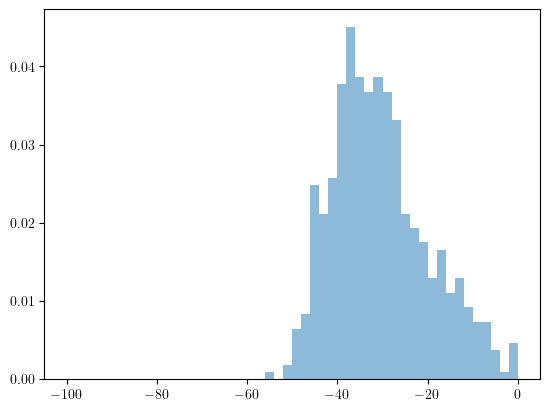

In [31]:
plt.hist(eqtf_pot.cpu().numpy(), bins=50, density=True, alpha=0.5,range=(-100,0), label='eqtf_pair samples')

In [ ]:
xt2, target_log_prob2, weights2, dists_v2 = generate_samples_and_prob(etvf)

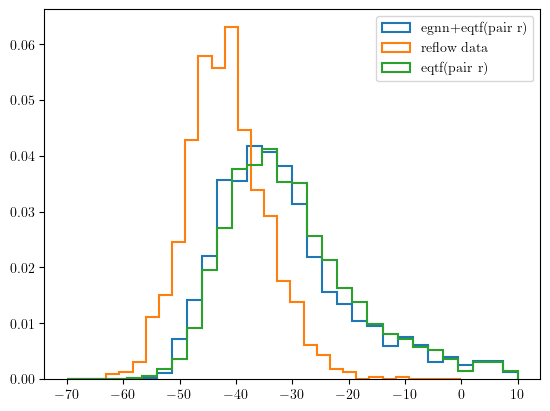

In [ ]:
plt.hist(etvf_pot.cpu().numpy(),range=(-70,10),bins=30, histtype='step',   
         fill=False,linewidth=1.5,density=True, label="egnn+eqtf(pair r)")
plt.hist(pot.cpu().numpy(),range=(-70,0),bins=30,histtype='step',   
         fill=False,linewidth=1.5,density=True, label="reflow data")
plt.hist(eqtf_pot.cpu().numpy(),range=(-70,10),bins=30,histtype='step',   
         fill=False,linewidth=1.5,density=True, label="eqtf(pair r)")
plt.legend()
plt.show()


In [9]:
def test_equivariance(model):
    import math

    device = next(model.parameters()).device
    torch.manual_seed(0)  # For reproducibility

    n_particles = 13
    n_batch = 1

    # Generate random positions for 13 particles in 3D
    xs = torch.randn(n_batch, n_particles, 3, device=device)
    t = torch.tensor([0.0], device=device)

    # # --- Rotation Equivariance Test ---
    # theta = math.pi / 3  # 60 degrees rotation
    # R = torch.tensor([[math.cos(theta), -math.sin(theta)],
    #                   [math.sin(theta),  math.cos(theta)]], dtype=torch.float32, device=device)
    # xs_rot = torch.matmul(xs, R.T)

    vel = model(xs, t)
    # vel_rot = model(xs_rot, t)
    # vel_rot_expected = torch.matmul(vel, R.T)

    # err_rotation = (vel_rot - vel_rot_expected).abs().max().item()
    # print(f"[Rotation equivariance error]: {err_rotation:.6e}")

    # --- Permutation Equivariance Test ---
    perm = torch.randperm(n_particles, device=device)
    xs_perm = xs[:, perm, :]
    vel_perm = model(xs_perm, t)
    print(vel_perm.shape)
    vel_expected = vel[:, perm, :]

    err_perm = (vel_perm - vel_expected).abs().max().item()
    print(f"[Permutation equivariance error]: {err_perm:.6e}")

    # --- Center of Mass Preservation Test ---
    com_input = xs.mean(dim=1)  # should be (0, 0)
    com_output = vel.mean(dim=1)  # check output COM
    err_com = com_output.norm(dim=-1).max().item()
    print(f"[Center of mass error]: {err_com:.6e}")


In [50]:
xt = rearrange(xt, 'l b p d -> (l b) p d')
target_log_prob = rearrange(target_log_prob, 'l b -> (l b)')
xt_bin, xt_g_r = ljsystem.g_r(xt, bins=100)

0
2
4
6
8
10
12
14
16
18


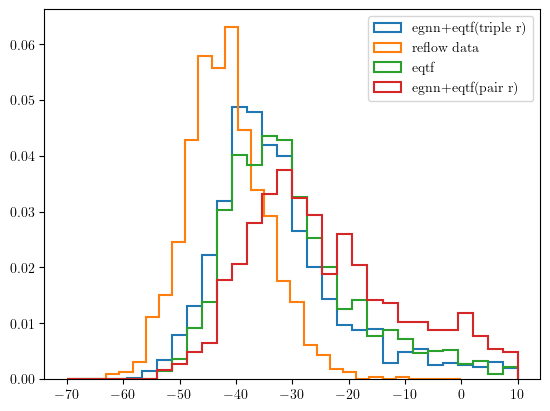

In [62]:
xt_bin, xt_g_r = ljsystem.g_r(xt2, bins=100)
dists_v = torch.norm(xt2.unsqueeze(2) - xt2.unsqueeze(1), dim=-1)  # shape (batch, N, N)
mask = ~torch.eye(xt2.shape[1], device=xt.device).bool()
dists_v = dists_v[:, mask].reshape(-1)


velocity_potential = ljsystem.potential(xt2, turn_off_harmonic=True).flatten()/temp
weight_potential = ljsystem.potential(xt2, turn_off_harmonic=False).flatten()/temp

#weight_potential = lj_energy(xt, oscillator_scale=1).flatten()
weights = torch.exp(-weight_potential)/ torch.exp(target_log_prob2)
weights /= weights.max()  # shift weights

ref_velocity_potential = ljsystem.potential(data, turn_off_harmonic=True).flatten()/temp
ref_weight_potential = ljsystem.potential(data, turn_off_harmonic=False).flatten()/temp



/home/sherryli/xsli/softwares/anaconda3/envs/lightning/lib/python3.11/site-packages/numpy/lib/histograms.py:885: invalid value encountered in divide


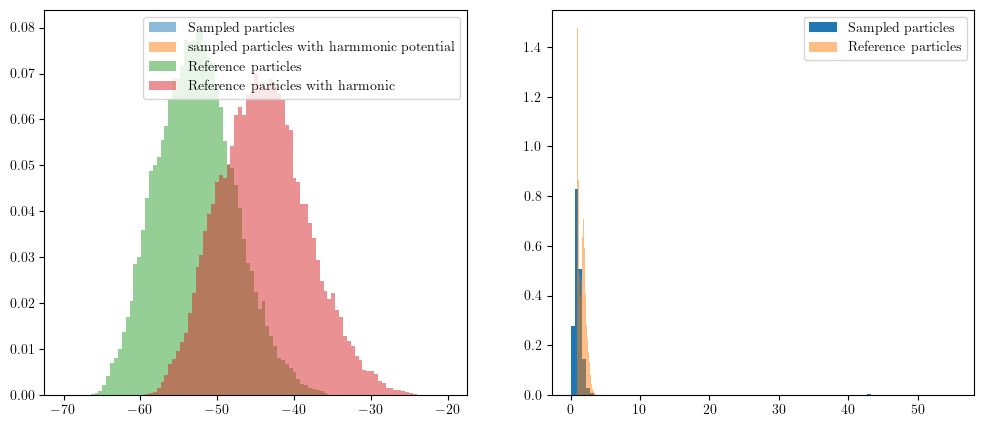

In [63]:
fix, ax = plt.subplots(1, 2, figsize=(12, 5))

bins = np.linspace(-70, -20, 100)
ax[0].hist(velocity_potential.cpu().numpy(),bins=bins,density=True, alpha=0.5, label='Sampled particles')
ax[0].hist(weight_potential.cpu().numpy(), bins=bins, density=True, alpha=0.5, label='sampled particles with harmmonic potential')

ax[0].hist(ref_velocity_potential.cpu().numpy(), bins=bins, density=True, alpha=0.5, label='Reference particles')
ax[0].hist(ref_weight_potential.cpu().numpy(), bins=bins, density=True, alpha=0.5, label='Reference particles with harmonic')
ax[0].legend()


ax[1].hist(dists_v.cpu().numpy(), bins=100, density=True, label='Sampled particles')
ax[1].hist(dists.cpu().numpy(), bins=100, density=True, alpha=0.5, label='Reference particles')
ax[1].legend()
plt.show()

watch out, rdf and dists don't really give the same type of curves.

- test raw samples

- weight

Text(0, 0.5, 'Weight Potential')

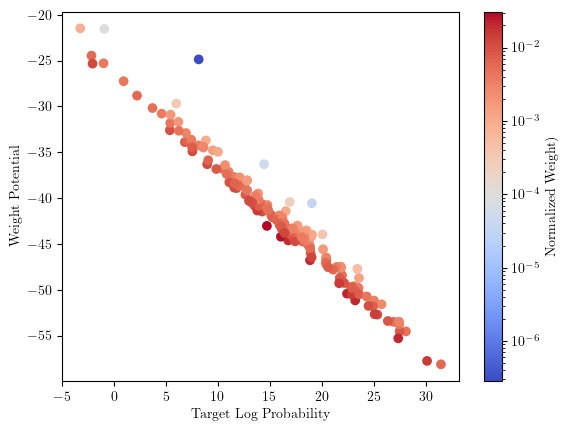

In [16]:
weights_norm = (weights / weights.sum()).cpu().numpy()
from matplotlib.colors import LogNorm
sc = plt.scatter(target_log_prob.cpu().numpy(), weight_potential.cpu().numpy(),c=weights_norm,cmap='coolwarm', norm=LogNorm())
plt.colorbar(sc, label='Normalized Weight)')
plt.xlabel("Target Log Probability")
plt.ylabel("Weight Potential")


- effective smaple size

In [17]:
normalized_weights = weights / weights.sum()
print(f'EFF : {(1 / (normalized_weights ** 2).sum()) / weights.shape[0]}')

EFF : 0.5990796089172363


In [58]:
normalized_weights.shape

torch.Size([400])

- weighted histogram

tensor(381, device='cuda:0')


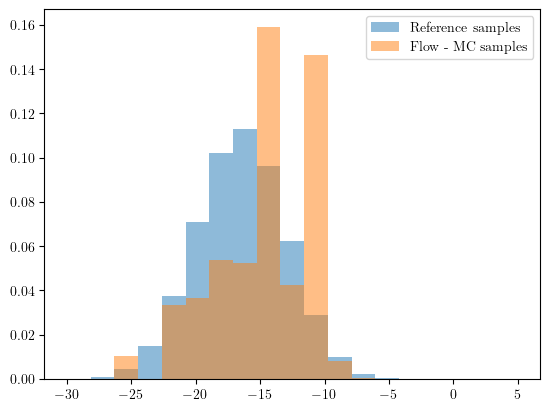

In [23]:
bins = np.linspace(-30, 5, 20)
filter = (weights_norm < 0.01)
print(filter.sum())
filter = torch.ones_like(weights_norm, dtype=bool)
plt.hist(ref_potential.cpu().numpy(), bins=bins, density=True, alpha=0.5, label='Reference samples')
plt.hist(velocity_potential[filter].cpu().numpy(), weights=weights[filter].cpu().numpy(), bins = bins, density=True, alpha=0.5, label='Flow - MC samples')
# plt.yscale('log')
plt.legend()
plt.show()
# print(f"% of sub 0 flow energy confs : {((velocity_potential < 0).sum() / velocity_potential.shape[0]) * 100}\n")

looks pretty good now ! 
- rdf


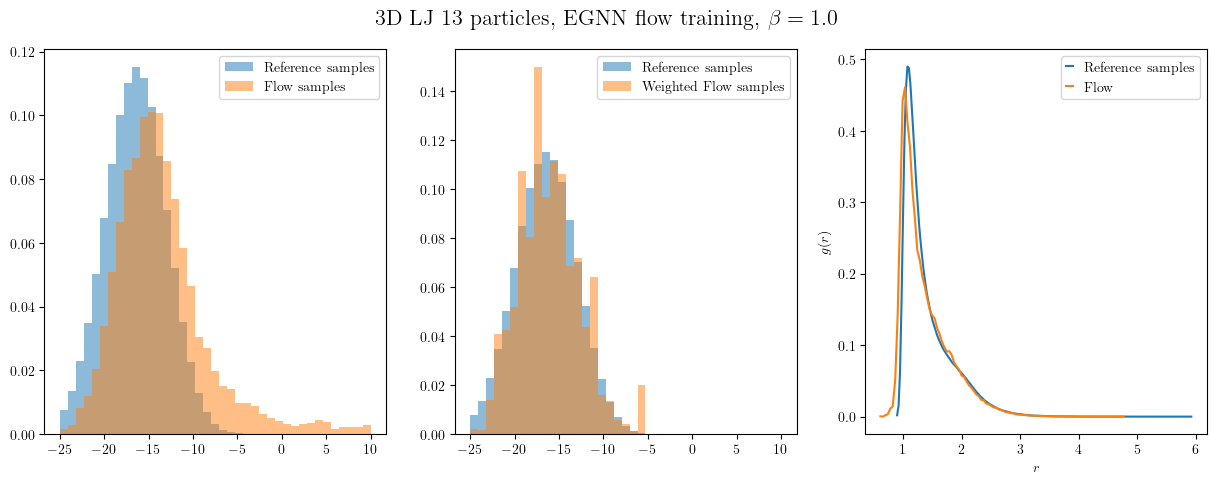

In [110]:

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle(r'3D LJ 13 particles, EGNN flow training, $\beta = 1.0$', fontsize = 16, y = 0.96)
bins = np.linspace(-25, 10, 40)
ax[0].hist(ref_potential.cpu().numpy(), bins=bins, density=True, alpha=0.5, label='Reference samples')
ax[0].hist(velocity_potential.cpu().numpy(), bins=bins, density=True, alpha=0.5, label='Flow samples')
# ax[0].set_yscale('log')
ax[0].legend()

bins = np.linspace(-25, 10, 40)
ax[1].hist(ref_potential.cpu().numpy(), bins=bins, density=True, alpha=0.5, label='Reference samples')
ax[1].hist(velocity_potential.cpu().numpy(), weights=weights.cpu().numpy(), bins=bins, density=True, alpha=0.5, label='Weighted Flow samples')
ax[1].legend()

ax[2].plot(ref_bin[:-1], ref_g_r, label='Reference samples')
ax[2].plot(xt_bin[:-1], xt_g_r, label='Flow')

# ax[2].set_yscale('log')
ax[2].legend(handlelength=0.5, loc='upper right')
ax[2].set_xlabel(r'$r$')
ax[2].set_ylabel(r'$g(r)$')

temp = 1.0
fname = f'lj13_3d_egnn_flowtraining_{temp}_v1'
# plt.savefig(f'../figures/{fname}.png', bbox_inches='tight')